In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# Loading the ASL dataset

In [ ]:
train_df = pd.read_csv("./input_data/sign_mnist_train.csv")
test_df = pd.read_csv("./input_data//sign_mnist_test.csv")

In [ ]:
test = pd.read_csv("./input_data//sign_mnist_test.csv")
y = test['label']

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization and Preprocessing

<AxesSubplot:xlabel='label', ylabel='count'>

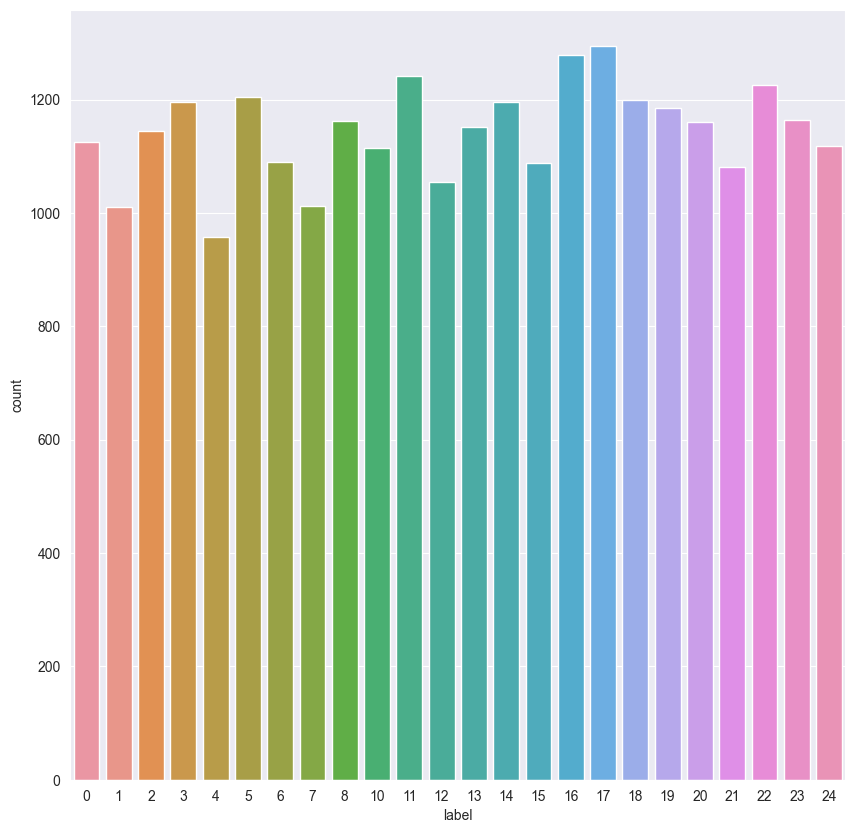

In [ ]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df, x = 'label')

**The dataset seems balanced as for each training label , enough training examples exist**

In [ ]:
y_train = train_df['label']
y_test = test_df['label']
y_debug = y_train[0:10]
del train_df['label']
del test_df['label']

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train = train_df.values
x_test = test_df.values

#### for debugging

In [ ]:
x_tmp = x_train[0]
x_tmp=x_tmp.reshape(1,28,28,1)
x_tmp = np.array(x_tmp)
# x_tmp = [x_tmp]
x_tmp.shape

(1, 28, 28, 1)

In [ ]:
np.transpose(y_debug).shape

(10,)

In [ ]:
# I will use this for debuggin on the ESP32
x_debug = (train_df.values)[0:10]
csv_x_debug = 'csv_x.csv'
csv_y_debug = 'csv_y.csv'
y_db2 = np.array(y_debug).reshape(1,-1)
# Write data to the CSV file
np.savetxt(csv_x_debug, x_debug, delimiter=',', fmt='%s')
np.savetxt(csv_y_debug, y_db2, delimiter=',', fmt='%s')

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [ ]:
# Normalize the data
x_train = (x_train  / 127.5) - 1.0
x_test = (x_test/127.5)-1.0# - 128 # / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [ ]:
x_train.shape

(27455, 28, 28, 1)

**Preview of first 10 images**

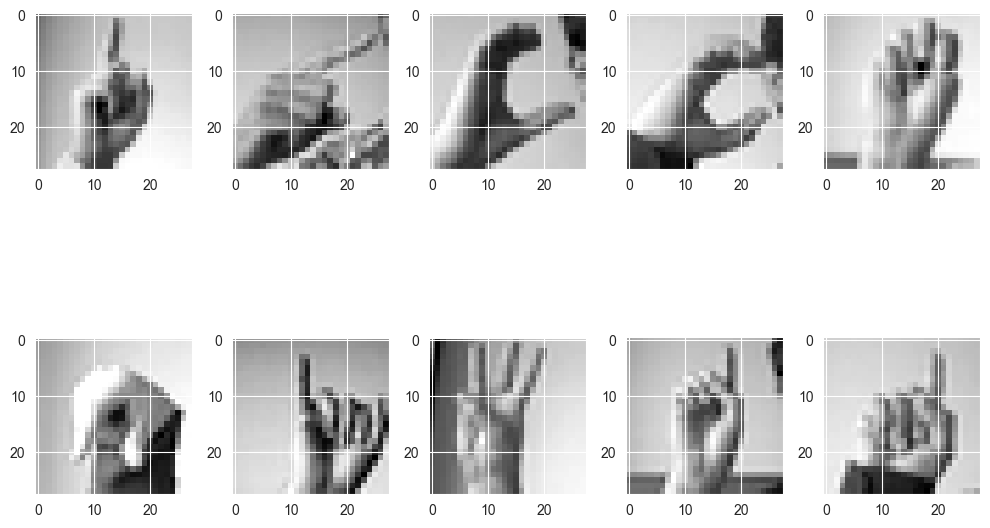

In [ ]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training The Model

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
#65 to 75, 40 to 75, 128 to 64
model.add(Conv2D(65 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(40 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 65)        650       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 65)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 40)        23440     
                                                                 
 dropout (Dropout)           (None, 14, 14, 40)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 40)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 25)          9

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 20s 92ms/step - loss: 1.8418 - accuracy: 0.4267 - val_loss: 0.6824 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 21s 98ms/step - loss: 0.6271 - accuracy: 0.7902 - val_loss: 0.2561 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 21s 98ms/step - loss: 0.3606 - accuracy: 0.8781 - val_loss: 0.1525 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 21s 99ms/step - loss: 0.2387 - accuracy: 0.9226 - val_loss: 0.1018 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 23s 108ms/step - loss: 0.1796 - accuracy: 0.9390 - val_loss: 0.0688 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 26s 120ms/step - loss: 0.1434 - accuracy: 0.9522 - val_loss: 0.0618 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 26

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


225/225 [==============================] - 3s 14ms/step - loss: 0.0126 - accuracy: 0.9967
Accuracy of the model is -  99.665367603302 %


# Analysis after Model Training

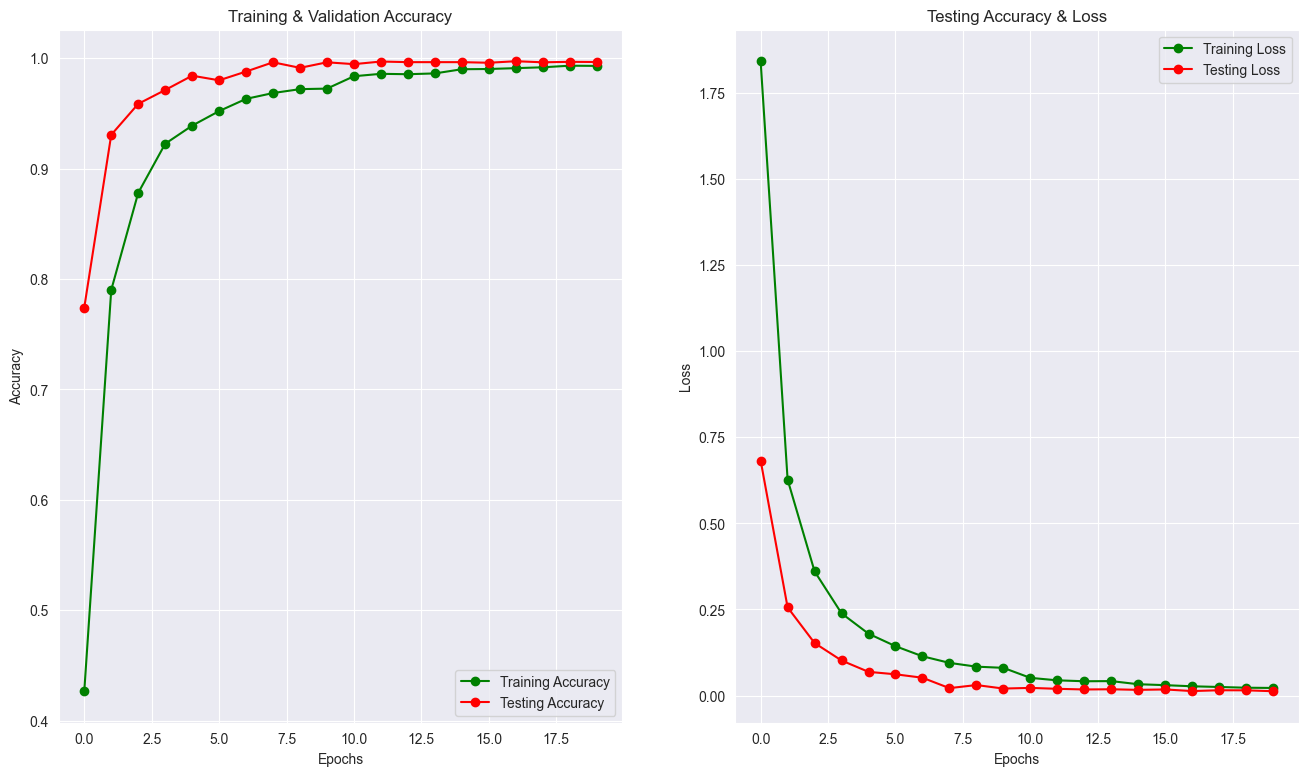

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
preds = model.predict(x_test)
predictions = np.argmax(preds, axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

225/225 [==============================] - 3s 11ms/step


array([ 6,  5, 10,  0,  3], dtype=int64)

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       0.96      1.00      0.98       498
     Class 5       0.98      1.00      0.99       247
     Class 6       1.00      0.95      0.97       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

<AxesSubplot:>

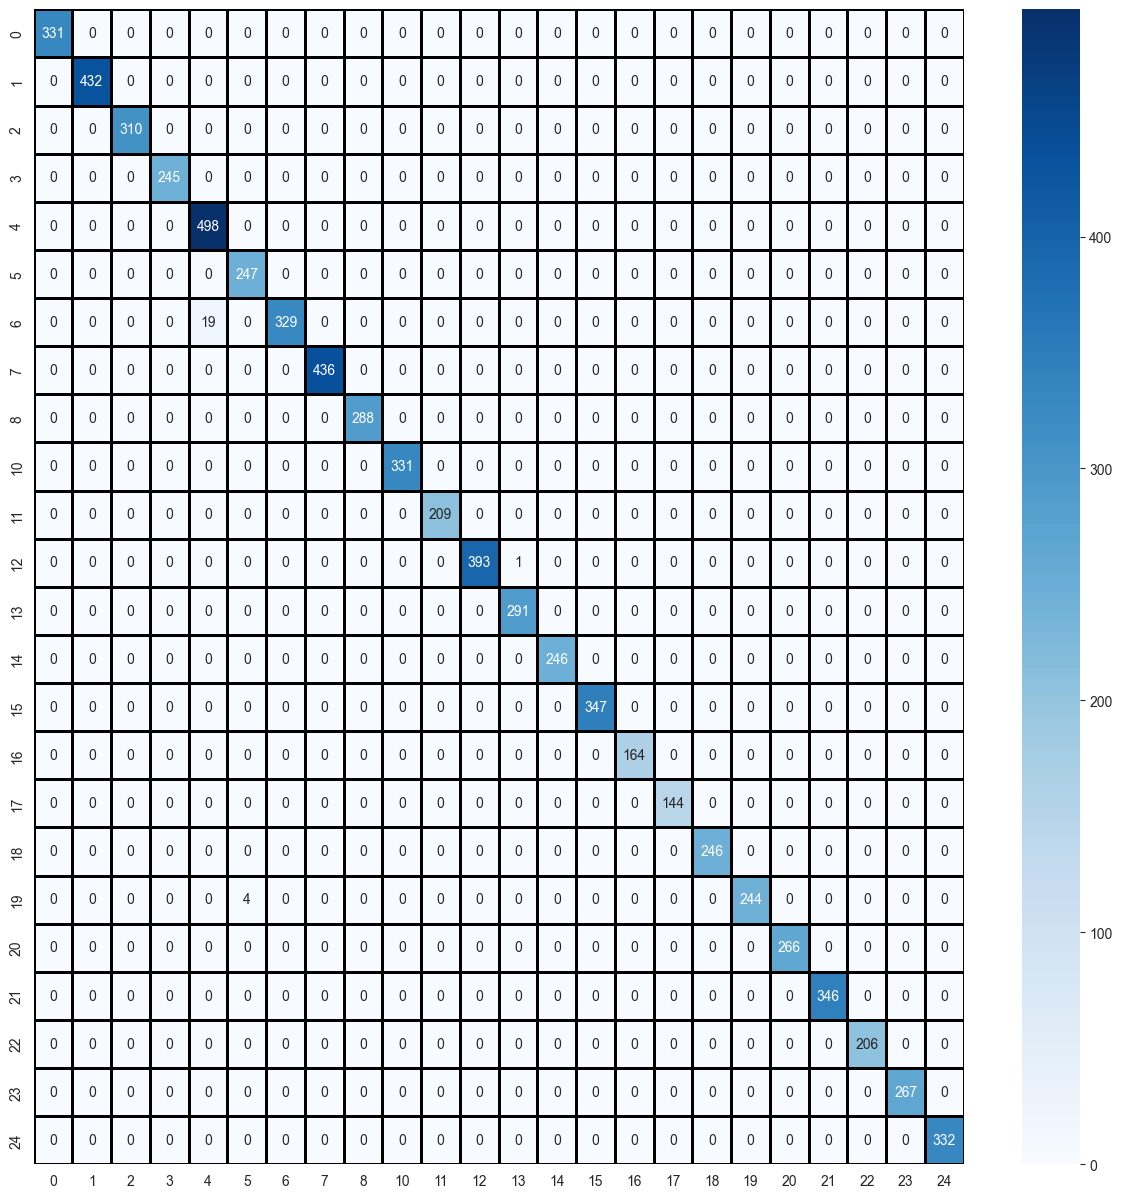

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

**Some of the Correctly Predicted Classes**

In [ ]:
print(np.array(predictions).shape)
print(y.shape)

(7172,)
(7172,)


In [ ]:
correct = np.nonzero(np.array(predictions) == np.array(y))[0]

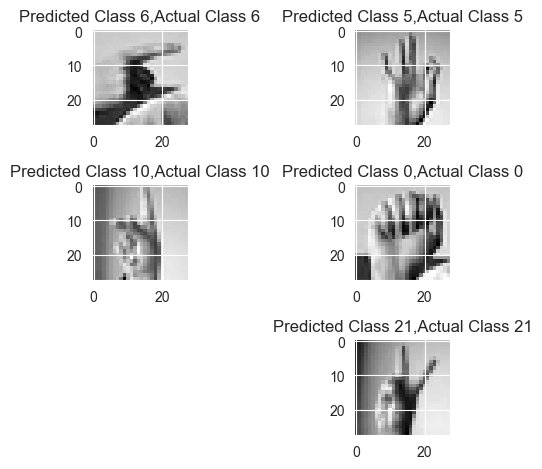

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [ ]:
model.save('ASL_4.h5')

In [ ]:
## see https://notebook.community/jhseu/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant


In [ ]:

import tensorflow.compat.v1 as tf
# x_test_flat=tf.cast(tf.squeeze(x_test, axis=-1), tf.float32) / 255.0
x_test_flat=tf.cast(x_test, tf.float32)# / 255.0
print(x_test_flat.shape)
xtest_ds = tf.data.Dataset.from_tensor_slices((x_test_flat)).batch(1)

(7172, 28, 28, 1)


In [ ]:
print(xtest_ds)
def representative_data_gen():
    for input_value in xtest_ds.take(100):
        yield [input_value]

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [ ]:
# xtest_rd = test_df.values
def representative_dataset():
    xtest_rd = test_df.values
    for i in range(250):
        nxt = (xtest_rd[i])
        nxt = nxt.reshape(1,28,28,1)
        nxt = np.array(nxt)
        nxt = ((nxt/127.5)-1.0).astype(np.float32)
        yield([nxt])



In [ ]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf
converter = tf.lite.TFLiteC
onverter.from_keras_model(model)

converter.representative_dataset = representative_dataset#representative_dataset_gen

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

#Implement optimization strategy for smaller model sizes
# converter.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size

# converter.representative_dataset = representative_data_gen

# tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8,tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\jonny\AppData\Local\Temp\tmpx1ixxcev\assets


INFO:tensorflow:Assets written to: C:\Users\jonny\AppData\Local\Temp\tmpx1ixxcev\assets
C:\Users\jonny\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\lite\python\convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
open("ASL_256_lite.tflite", "wb").write(tflite_model)

151000

In [ ]:
## xxd -i ASL_1_lite.tflite > ASL_1.cc

In [ ]:
tflite_model_path = "ASL_256_lite.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[ 1 28 28  1]
[ 1 24]


In [ ]:
nin = 600
nstrt = 1500

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (nin, 28, 28,1))
interpreter.resize_tensor_input(output_details[0]['index'], (nin, 24))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [600  28  28   1]
Input Type: <class 'numpy.int8'>
Output Shape: [600  24]
Output Type: <class 'numpy.int8'>


In [ ]:
# test_imgs_numpy = np.array(x_test[nstrt:(nstrt+nin),:,:,:], dtype=np.float32)
test_imgs_numpy = np.array(x_test[nstrt:(nstrt+nin),:,:,:]*127.5, dtype=np.int8)
test_imgs_numpy.shape

from time import time
t1 = time()
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print((time()-t1)/nin)
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

0.00024320602416992188
Prediction results shape: (600, 24)


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediction_classes, np.argmax(y_test[nstrt:(nstrt+nin),:],axis=1))

print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.9966666666666667
